In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

np.random.seed(163)

%run "DiffKf.ipynb"
%run "KF.ipynb"

In [ ]:
dt = 10

C = np.array([[0.34,0.33, 0, 0, 0.33],[0.33,0.34,0.33,0,0],[0,0.33,0.34,0.33,0],[0,0,0.33,0.34,0.33],[0.33,0,0,0.33,0.34]])
num_stns = len(C[0])

A = np.array([[1, dt, 0, 0], [0, 1, 0, 0],[0,0,1,dt], [0, 0, 0, 1]])
H = np.array([[1, 0, 0, 0],[0,0,1,0]])

dkf_state_size = len(A)
dkf_measure_size = len(H)

q = 0.001
Q = q*np.array([[(dt**3)/3, (dt**2)/2, 0, 0], [(dt**2)/2, dt, 0, 0],[0,0,(dt**3)/3,(dt**2)/2], [0, 0, (dt**2)/2, dt]])
R = np.array([[4,0],[0,4]])

A_kf = np.kron(np.eye(num_stns),A)
H_kf = np.kron(np.eye(num_stns),H)
Q_kf = np.kron(np.eye(num_stns),Q)
R_kf = np.kron(np.eye(num_stns),R)

kf_state_size = A_kf.shape[0]
kf_measure_size = R_kf.shape[0]

F = [A for _ in range(num_stns)]
G = [np.eye(dkf_state_size) for _ in range(num_stns)]
H_dkf = [H for _ in range(num_stns)]

Q_dkf = [Q for _ in range(num_stns)]
R_dkf = [R for _ in range(num_stns)]

In [ ]:
procc_noise_kf = lambda : np.linalg.cholesky(Q_kf) @ np.random.normal(np.array([[0 for _ in range(kf_state_size)]]).T)
measure_noise_kf = lambda : np.linalg.cholesky(R_kf) @ np.random.normal(np.array([[0 for _ in range(kf_measure_size)]]).T)

measure_kf_to_dkf  = lambda z: [np.array([z[dkf_measure_size*i + j] for j in range(dkf_measure_size)]) for i in range(num_stns)]
state_kf_to_dkf = lambda z: [np.array([z[dkf_state_size*i + j] for j in range(dkf_state_size)]) for i in range(num_stns)]

In [ ]:
#True Initial
x0_kf = np.array([[np.random.normal(0,np.sqrt(Q_kf[i,i])) for i in range(kf_state_size)]]).T


#Initial Estimate
x_kf = np.array([[np.random.normal(0,5) for i in range(kf_state_size)]]).T
x_dkf = state_kf_to_dkf(x_kf)


P_kf = 10*np.copy(Q_kf)
P_dkf = [10*np.copy(Q) for _ in range(num_stns)]

kf = KalmanFilter(A = A_kf,H = H_kf, Q = Q_kf, R = R_kf,P=P_kf,x0=x_kf)

dkf = DiffKF(C,F,G,H_dkf,R_dkf,Q_dkf,x_dkf,P_dkf)

In [ ]:

iters = 60

truth = np.zeros((iters+1,kf_state_size,1))
truth[0] = x0_kf

measurements = np.zeros((iters+1,kf_measure_size,1))
measurements[0] = (H_kf @ x0_kf)+measure_noise_kf()


predictions_kf = np.zeros((iters,kf_state_size,1))
predictions_dkf = np.zeros((iters,num_stns,dkf_state_size,1))

errors_kf = np.zeros((iters,kf_state_size,1))
errors_dkf = np.zeros((iters,num_stns,dkf_state_size,1))

P_hist_kf = np.zeros((iters,kf_state_size,kf_state_size))
P_hist_dkf = np.zeros((iters, num_stns, dkf_state_size,dkf_state_size))

for i in range(iters):

    kf.update(measurements[i])
    dkf.update(measure_kf_to_dkf(measurements[i]))

    predictions_dkf[i] = [dkf.nodes[j].x for j in range(num_stns)]
    errors_dkf[i] = [dkf.nodes[j].x-state_kf_to_dkf(truth[i])[j] for j in range(num_stns)]
    P_hist_dkf[i] = [dkf.nodes[j].P for j in range(num_stns)]

    predictions_kf[i] = kf.x
    errors_kf[i] = kf.x-truth[i]
    P_hist_kf[i] = kf.P

    kf.predict()
    dkf.predict()

    truth[i+1] = A_kf@x0_kf + procc_noise_kf()
    measurements[i+1] = H_kf @ truth[i+1] + measure_noise_kf()

[[-4.23085219]
 [ 2.98615481]
 [-4.95988762]
 [ 1.22410234]
 [-1.95005992]
 [ 9.24047932]
 [ 4.94396616]
 [ 6.20634323]
 [-4.84515698]
 [ 0.91893313]] [[-1.47769971]
 [ 2.61719436]
 [ 0.41833435]
 [-2.41821768]
 [-0.59206034]
 [-1.22452022]
 [-0.36890173]
 [-0.3421304 ]
 [ 2.82673517]
 [-1.52643188]]
[[  -8.09561101]
 [   9.88633544]
 [  46.34920569]
 [  48.46062686]
 [  46.72654736]
 [   3.64179895]
 [-108.80839237]
 [ -39.32591096]
 [  25.25575774]
 [  18.35364668]] [[ 0.77219178]
 [-1.65928914]
 [ 5.85769435]
 [-3.20391903]
 [ 0.50841295]
 [ 2.27931837]
 [ 1.8705552 ]
 [ 2.11622722]
 [-2.15069815]
 [-0.21832059]]
[[ -1.50866587]
 [  1.71707718]
 [ 41.77564643]
 [ 29.16931655]
 [ 33.79025925]
 [  1.00182521]
 [-74.07908997]
 [-27.18900586]
 [ 15.70022928]
 [ 12.38984139]] [[ 1.98246126]
 [-1.56881639]
 [ 2.72744234]
 [-3.27732737]
 [ 1.66721553]
 [ 2.16149518]
 [ 1.79916961]
 [-1.73235842]
 [-0.94335046]
 [-0.8224051 ]]
[[  1.88713982]
 [ -0.95272843]
 [ 27.10229344]
 [ 15.54351284]


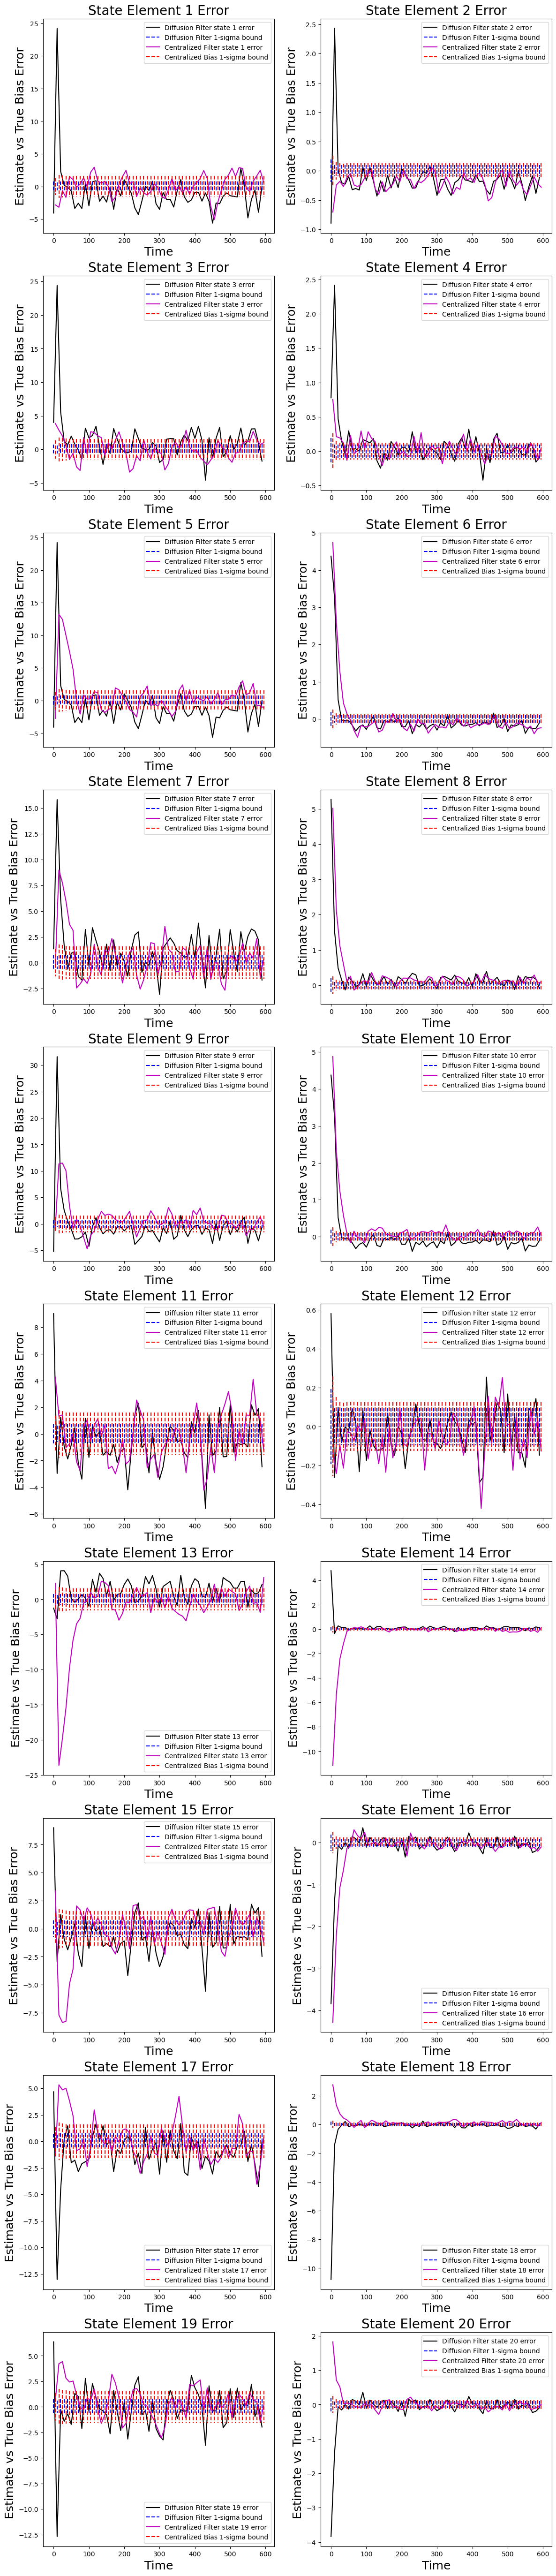

In [ ]:
num_rows = -1*((-1*kf_state_size)//2)
fig,axs = plt.subplots(num_rows,2, figsize=(14, 7*num_rows))
t_hist_dkf = np.arange(0, dt*iters, dt)
t_hist_kf = np.arange(dt/2, dt*iters, dt)

for i in range(kf_state_size):
    axs[i//2][i%2].plot(t_hist_dkf, errors_dkf[:, i//num_stns,i%dkf_state_size,0], 'k', label = f"Diffusion Filter state {i+1} error")
    dkf_cov = np.sqrt(P_hist_dkf[:, i//num_stns,i%dkf_state_size,i%dkf_state_size])
    axs[i//2][i%2].plot(np.vstack([t_hist_dkf[0], t_hist_dkf[0]]), np.vstack([dkf_cov[0], -dkf_cov[0]]), 'b--', label = "Diffusion Filter 1-sigma bound")
    axs[i//2][i%2].plot(np.vstack([t_hist_dkf[1:], t_hist_dkf[1:]]), np.vstack([dkf_cov[1:], -dkf_cov[1:]]), 'b--')
    kf_error = errors_kf[:, i,0]
    kf_cov = np.sqrt(P_hist_kf[:, i, i])
    axs[i//2][i%2].plot(t_hist_kf, kf_error,'m',label=f'Centralized Filter state {i+1} error')
    axs[i//2][i%2].plot(np.vstack([t_hist_kf[0], t_hist_kf[0]]), np.vstack([kf_cov[0], -kf_cov[0]]), 'r--',label = "Centralized Bias 1-sigma bound")
    axs[i//2][i%2].plot(np.vstack([t_hist_kf[1:], t_hist_kf[1:]]), np.vstack([kf_cov[1:], -kf_cov[1:]]), 'r--')
    axs[i//2][i%2].legend()
    axs[i//2][i%2].set_title("State Element "+str(i+1)+" Error", fontsize = 20)
    axs[i//2][i%2].set_xlabel("Time", fontsize = 18)
    axs[i//2][i%2].set_ylabel("Estimate vs True Bias Error", fontsize = 18)

In [ ]:
def bhattacharyya_distance(mu1, mu2, Sigma1, Sigma2):
    # mu1 = mean of diffusion KF
    # mu2 = mean of centralized KF
    # Sigma1 = covariance of diffusion KF
    # Sigma2 = covariance of centralized KF
    Sigma = (Sigma1 + Sigma2) / 2
    inv_Sigma = np.linalg.inv(Sigma)

    term1 = 1/8 * np.dot(np.dot((mu1 - mu2).T, inv_Sigma), (mu1 - mu2))
    term2 = 1/2 * np.log(np.linalg.det(Sigma) / np.sqrt(np.linalg.det(Sigma1) * np.linalg.det(Sigma2)))

    return term1 + term2

# centralized
mu2 = kf.x
Sigma2 = kf.P

# diffusion
# mu1
n_i1 = np.random.normal(loc=0, scale=1, size=m)
v_i = np.random.normal(loc=0, scale=1, size=m)
tilde_x_i_i1 = truth[0]


S_i = np.sum(np.dot(H_n, np.dot(np.linalg.inv(R_dkf), H_n)))

# compute the state (equation 30)
term1 = np.dot(C.T, np.dot(np.identity(20) - np.dot(P_dkf, S_i), np.dot(np.kron(np.identity(20), F), tilde_x_i_i1)))
term2 = np.dot(np.kron(np.identity(20), G), np.kron(np.ones((20,20)), n_i1))
term3 = np.dot(C.T, np.dot(P_dkf, np.dot(H_n.T, np.dot(np.linalg.inv(R_dkf), v_i))))
mu1 = term1 + term2 - term3

# Sigma1
# compute the covariance (equation 32)
F_chi_i = np.dot(C.T, np.dot(np.identity(2) - np.dot(P_dkf, S_i), np.kron(np.identity(1), F)))
G_i = np.dot(C.T, np.dot(np.identity(2) - np.dot(P_dkf, S_i), np.kron(np.identity(1), G)))
D_i = np.dot(C.T, np.dot(P_dkf, np.dot(H_n.T, np.linalg.inv(R_dkf))))
term1 = np.dot(F, np.dot(P_hist_dkf, F_chi_i.T))
term2 = np.dot(G_i, np.dot(np.kron(np.ones((1, 1)), Q_dkf), G_i.T))
term3 = np.dot(D_i, np.dot(R_dkf, D_i.T))

Sigma1 = term1 + term2 + term3

# compute the Bhattacharya distance
print("The Bhattacharya Distance is: ", bhattacharyya_distance(mu1, mu2, Sigma1, Sigma2))